In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product
warnings.filterwarnings('ignore')

/var/folders/8t/_xbd4d4117l1s7h5p9tj9rxr0000gn/T/ipykernel_5965/1964029187.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
cb = pd.read_csv('CBA.AX5y.csv')

In [3]:
cb.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-21,76.000000,76.889999,75.900002,76.070000,60.625332,4104401
1,2017-09-22,76.199997,77.050003,76.180000,76.620003,61.063652,2170239
2,2017-09-25,77.029999,77.269997,75.739998,75.809998,60.418121,2003512
3,2017-09-26,75.800003,75.860001,75.080002,75.099998,59.852276,2552948
4,2017-09-27,75.080002,75.349998,74.610001,74.849998,59.653019,2688235


In [4]:
cb.columns = cb.columns.str.lower()

In [5]:
cb.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj close', 'volume'], dtype='object')

In [6]:
cb['movement'] = cb['close'] - cb['open']

In [7]:
cb.tail()

,date,open,high,low,close,adj close,volume,movement
1262,2022-09-15,94.849998,95.339996,94.660004,95.059998,95.059998,3364419,0.210000
1263,2022-09-16,94.550003,95.279999,94.044998,94.230003,94.230003,5980478,-0.320000
1264,2022-09-19,94.250000,95.029999,94.250000,94.660004,94.660004,1474030,0.410004
1265,2022-09-20,95.949997,96.800003,95.660004,96.529999,96.529999,2389248,0.580002
1266,2022-09-21,96.279999,96.279999,95.750000,95.860001,95.860001,128860,-0.419998


In [8]:
cb.date = pd.to_datetime(cb['date'], format=None)

In [9]:
cb.set_index('date', inplace=True)

In [10]:
cb.dtypes

open         float64
high         float64
low          float64
close        float64
adj close    float64
volume         int64
movement     float64
dtype: object

In [11]:
comm = cb.drop(labels = ['open', 'high', 'low', 'close', 'adj close', 'volume'], axis=1)

In [12]:
comm.head()

,movement
date,
2017-09-21,0.070000
2017-09-22,0.420006
2017-09-25,-1.220001
2017-09-26,-0.700005
2017-09-27,-0.230004


In [13]:
comm.isnull().sum()

movement    0
dtype: int64

<AxesSubplot:xlabel='date'>

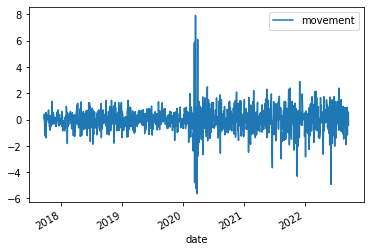

In [14]:
comm.plot()

### Moving Average

In [15]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    

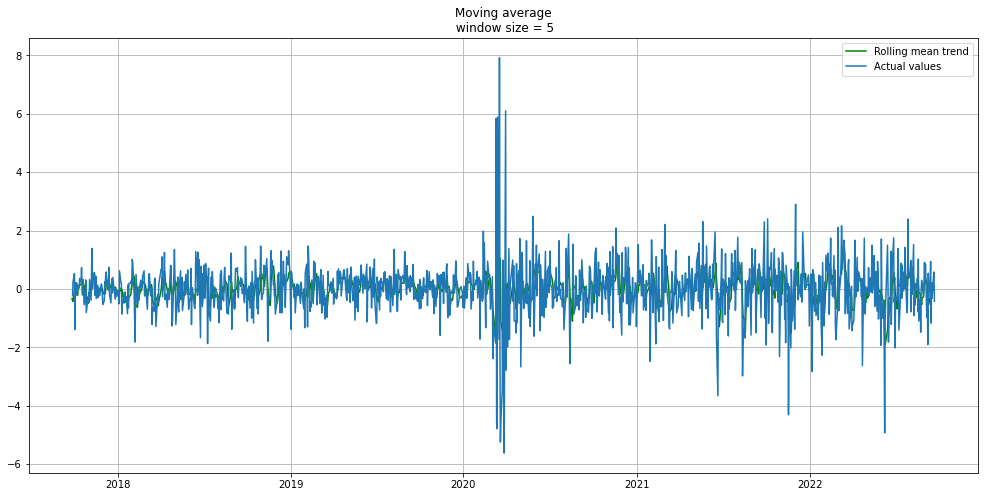

In [16]:
#Smooth by the previous 5 days (by week)
plot_moving_average(comm, 5)

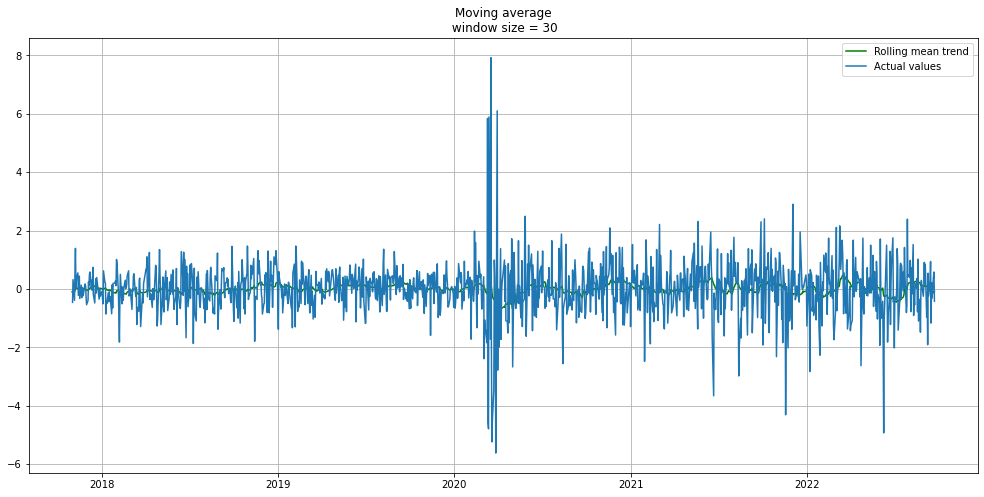

In [19]:
plot_moving_average(comm, 30)

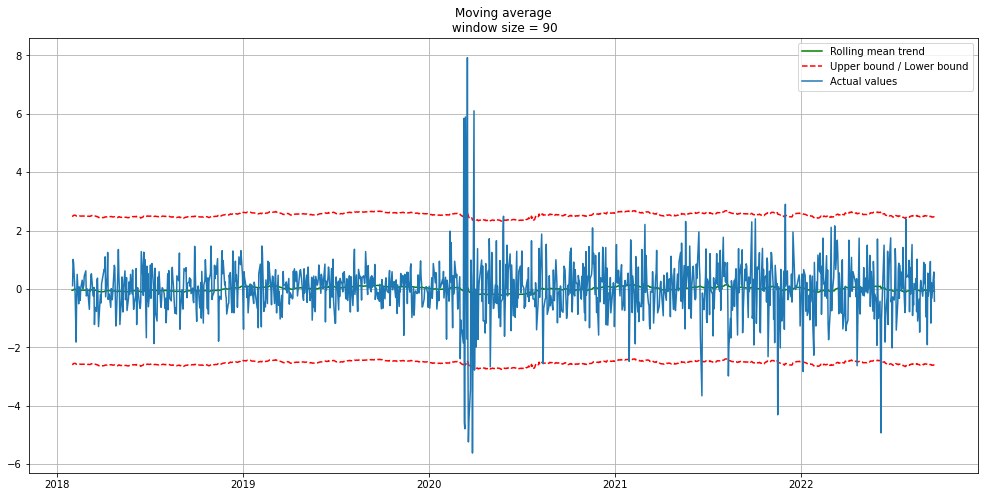

In [20]:
plot_moving_average(comm, 90, plot_intervals=True)

## Modelling

### Turn data series into Stationary using Dickey-Fuller test

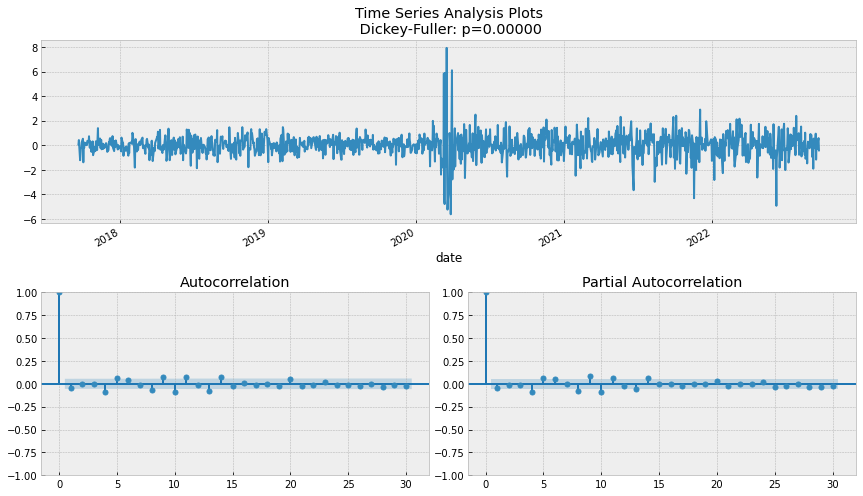

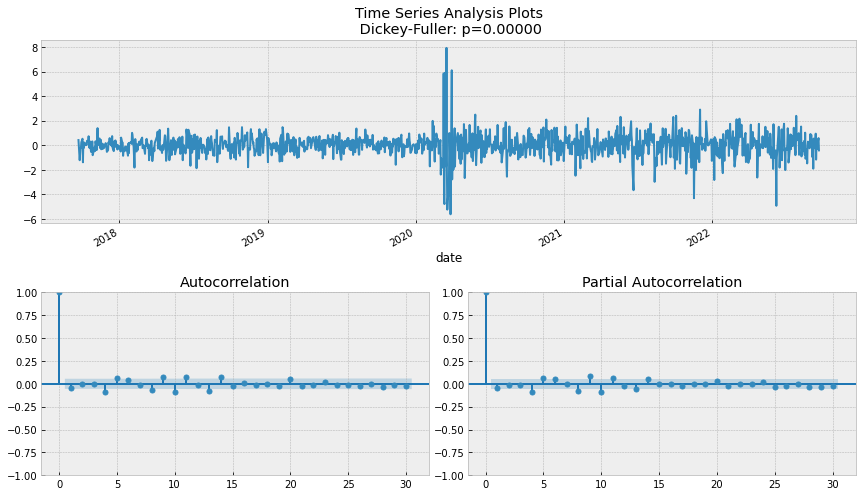

In [24]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(comm.movement, lags=30)

# Take the first difference to remove to make the process stationary
#data_diff = comm.movement - comm.movement.shift(1)

tsplot(comm.movement[1:], lags=30)

#### Our data is stationary and ready for modelling

### SARIMA

In [ ]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(comm.close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(comm.close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

### Make Predictions

In [36]:
#SARIMAX(2, 1, 2)x(2, 1, [1], 5)
len(comm)


1267

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68832D+00    |proj g|=  2.08748D-01

At iterate    5    f=  1.60928D+00    |proj g|=  1.28060D-01

At iterate   10    f=  1.58510D+00    |proj g|=  2.37679D-02

At iterate   15    f=  1.58260D+00    |proj g|=  5.72783D-03

At iterate   20    f=  1.58154D+00    |proj g|=  1.59821D-02

At iterate   25    f=  1.58102D+00    |proj g|=  7.92360D-03

At iterate   30    f=  1.58085D+00    |proj g|=  1.18147D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<AxesSubplot:>

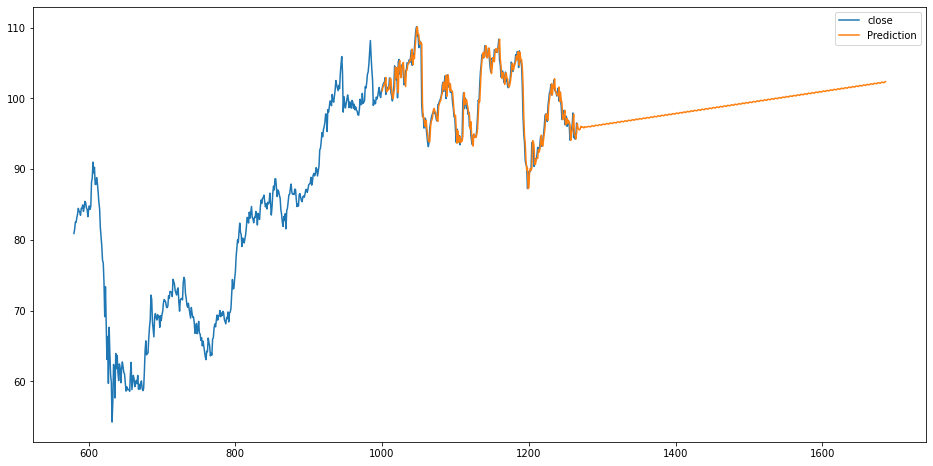

In [37]:
train_comm = comm.iloc[:1000]
test_comm = comm.iloc[580:]
mod = sm.tsa.statespace.SARIMAX(comm['close'], order=(2,1,2), seasonal_order=(2,1,1,5))
res = mod.fit()
start = len(train_comm)
end = len(train_comm) + len(test_comm) - 1 #index number starts from zero
prediction = res.predict(start, end).rename('Prediction')
ax = test_comm['close'].plot(legend=True, figsize = (16,8))
prediction.plot(legend=True)

19.085999063318322

In [39]:
from pandas.tseries.offsets import DateOffset

In [40]:
comm.tail()

,date,close
1262,2022-09-15,95.059998
1263,2022-09-16,94.230003
1264,2022-09-19,94.660004
1265,2022-09-20,96.529999
1266,2022-09-21,95.860001


In [44]:
commb = pd.concat([comm, fd], ignore_index=True)

In [45]:
commb.close = commb.close.astype(float)

In [46]:
commb.tail(10)

,date,close
2524,2022-09-15,NaN
2525,2022-09-16,NaN
2526,2022-09-19,NaN
2527,2022-09-20,NaN
2528,2022-09-21,NaN
2529,2022-09-22,NaN
2530,2022-09-23,NaN
2531,2022-09-26,NaN
2532,2022-09-27,NaN
2533,2022-09-28,NaN


In [47]:
fdates = pd.DataFrame(pd.date_range(comm["date"].min(), comm["date"].max() + pd.DateOffset(days=7))
,columns=['future_date'])

df_new = pd.concat([comm,fdates],axis=1)

In [50]:
fdates.tail(10)

,future_date
1824,2022-09-19
1825,2022-09-20
1826,2022-09-21
1827,2022-09-22
1828,2022-09-23
1829,2022-09-24
1830,2022-09-25
1831,2022-09-26
1832,2022-09-27
1833,2022-09-28


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83851D+00    |proj g|=  4.67167D-01

At iterate    5    f=  1.44240D+00    |proj g|=  7.48350D-02

At iterate   10    f=  1.38514D+00    |proj g|=  2.59458D-02

At iterate   15    f=  1.36331D+00    |proj g|=  8.61408D-03

At iterate   20    f=  1.36113D+00    |proj g|=  1.26618D-02

At iterate   25    f=  1.35910D+00    |proj g|=  1.85535D-03

At iterate   30    f=  1.35876D+00    |proj g|=  4.94069D-03

At iterate   35    f=  1.35843D+00    |proj g|=  1.31622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<AxesSubplot:>

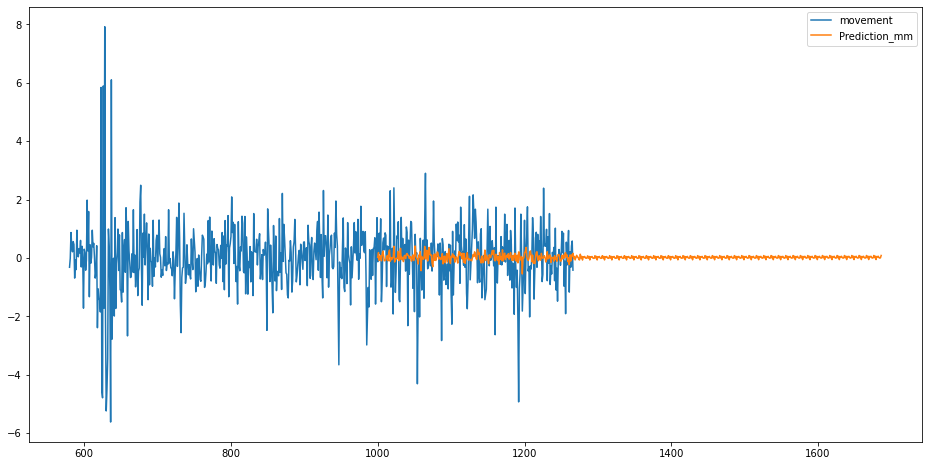

In [52]:
train_mm = mm.iloc[:1000]
test_mm = mm.iloc[580:]
model = sm.tsa.statespace.SARIMAX(mm['movement'], order=(2,1,2), seasonal_order=(2,1,1,5))
res = model.fit()
start = len(train_mm)
end = len(train_mm) + len(test_mm) - 1 #index number starts from zero
prediction = res.predict(start, end).rename('Prediction_mm')
ax = test_mm['movement'].plot(legend=True, figsize = (16,8))
prediction.plot(legend=True)